Importing modules

In [83]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

The Dataset contains four different features such as Parking_details_id, Parking_id, Spaces, and Updatedon. They were collected every Five minutess from 19th July 2022 till date. This information was collected from Nicosia Municipality for the study of Parking spaces Availabilty to assist in developing smart cities, where we can predict the parking availabity for any user.

In [84]:
#reading the parking_details dataset file
df = pd.read_csv('parking_details.csv')

## Slice [start:stop:step], starting from index 1 take every 4th record.
df = df[1::4]
df.head()

,parking_details_id,parking_id,spaces,updatedon
1,2,2,117,"Tue, 19 Jul 2022 10:58:57"
5,6,2,117,"Tue, 19 Jul 2022 10:58:57"
9,10,2,117,"Tue, 19 Jul 2022 10:58:57"
13,14,2,117,"Tue, 19 Jul 2022 10:58:57"
17,18,2,117,"Tue, 19 Jul 2022 10:58:57"


In [85]:
df.isnull().any()

parking_details_id    False
parking_id            False
spaces                False
updatedon             False
dtype: bool

The updatedon column is a sting format in the dataset. We will be using pandas to convert it pandas datetime format. Also, popping out of the table and saving it into the datetime variable.

In [86]:
#converting the updatedon column to pandas datetime format 
df['updatedon'] = pd.to_datetime(df['updatedon'])
date_time = pd.to_datetime(df.pop('updatedon'), format='%d.%m.%Y %H:%M:%S')

In [87]:
parking_details_id = df.pop('parking_details_id')
parking_id = df.pop('parking_id')

In [88]:
df.head()

,spaces
1,117
5,117
9,117
13,117
17,117


EVOLUTIONS OF FEATURES OVERTIME

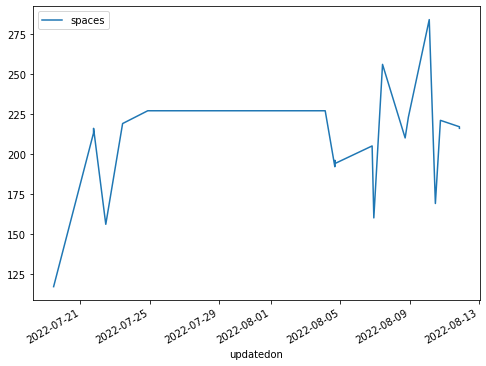

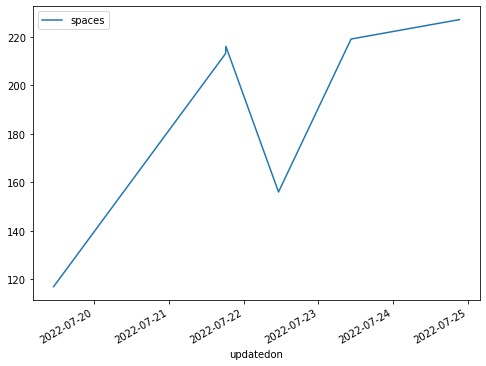

In [89]:
plot_cols = ['spaces']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1200]
plot_features.index = date_time[:1200]
_ = plot_features.plot(subplots=True)

To inspect and cleanup, we look at the statistics of the dataset using the .describe()

In [90]:
df.describe()

,spaces
count,5360.000000
mean,214.171082
std,30.276718
min,117.000000
25%,219.000000
50%,227.000000
75%,227.000000
max,284.000000


Next, we split the data. You will use a (70%, 20%, 10%) split for the training, validation, and tests set

In [91]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Before training a neural network, it is very important to scale the data by normilization. This process is to subtract the mean and divide by the standard deviation of each feature. The mean and standard deviation are only computed using the training data so that the models wont have access to the values validation and test results. This method ensures to get an honest matrics.

In [92]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In this category, we will apply data windowing. Data windowing will make a set of predictions based on as window of consecutive samples of the data. The main features of the input windows are the width, offset, and the features use as inputs, labels or both. This can be used to build a variety of CNN, DNN and RNN models for (single-output and multi-output predictions) and (single-time step and multi-time step predictions)

In [93]:
#Indexes and offsets
#creating a class for windows generator

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df = train_df, val_df = val_df, test_df = test_df,
               label_columns=None):
        
        #store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #work out the windows parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        

    def __repr__(self):
        return '\n' .join([
            f'Total window size: {self.total_window_size}',
            f'Input Indices: {self.input_indices}',
            f'Label Indices: {self.label_indices}',
            f'Label Column name(s): {self.label_columns}'])

In [94]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                    label_columns=['spaces'])

w1

Total window size: 48
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [47]
Label Column name(s): ['spaces']

Given a list of consecutive inputs, the split window method will convert them to a window of inputs and a window of labels

In [95]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
        
    #slicing doesnt preserve static shape information, so set the shapes
    #manually. This way the tf.data.Datasets are easier to inspect
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels


WindowGenerator.split_window = split_window

Given a list of consecutive inputs, the split window method will convert them to a window of inputs and a window of labels

In [96]:
#stack three slices, the length of the total window
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                          np.array(train_df[100:100+w1.total_window_size]),
                          np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All Shapes are: (batch, time, features)')
print(f'Window Shape: {example_window.shape}')
print(f'Inputs Shape: {example_inputs.shape}')
print(f'Labels Shape: {example_labels.shape}')

All Shapes are: (batch, time, features)
Window Shape: (3, 48, 1)
Inputs Shape: (3, 24, 1)
Labels Shape: (3, 1, 1)


In [97]:
w1.example = example_inputs, example_labels

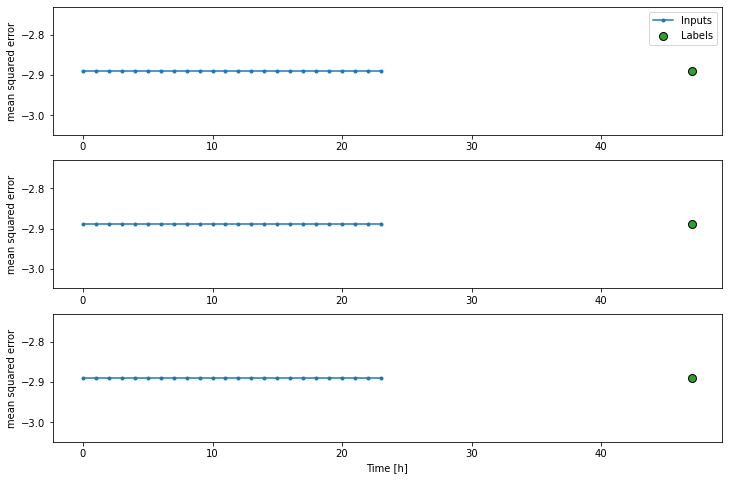

In [98]:
#plot
def plot(self, model=None, plot_col = ('spaces'), max_subplots=3, plot_feature = df[plot_cols]):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel('mean squared error')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                       marker='X', edgecolors='k', label='Predictions',
                       c='#ff7f0e', s=64)
            
        if n == 0:
            plt.legend()
            
            
    plt.xlabel('Time [h]')
    
    
WindowGenerator.plot = plot

w1.plot()

Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from array function

In [99]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    
    
    return ds
    

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation, and test data.

Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting

In [100]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        #No example of batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        #and cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the WindowGenerator object gives you access to the tf.data.Dataset objects, so you can easily iterate over the data.

The Dataset.element_spec property tells you the structure, data types, and shapes of the dataset elements.

In [101]:
#each element is an input (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [102]:
#Iterating over a Dataset yields concrete batches
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 1, 1)


The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

In [103]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['spaces'])
single_step_window

Total window size: 2
Input Indices: [0]
Label Indices: [1]
Label Column name(s): ['spaces']

In [104]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models. The first task is to predict parking availability 1 hour into the future, given the currrent values of all features. the current values include spaces

In [105]:
#Baseline model
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [106]:
#instantiate and evaluate model
baseline = Baseline(label_index=column_indices['spaces'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

34/34 [==============================] - 0s 901us/step - loss: 0.0126 - mean_absolute_error: 0.0071  


So, create a wider WindowGenerator that generates windows 24 hours of consecutive inputs and labels at a time. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps

In [107]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['spaces'])

wide_window

Total window size: 25
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label Column name(s): ['spaces']

In [108]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step

In [109]:
#recurrent model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [110]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
117/117 [==============================] - 3s 10ms/step - loss: 0.1701 - mean_absolute_error: 0.1936 - val_loss: 0.0954 - val_mean_absolute_error: 0.1850
Epoch 2/20
117/117 [==============================] - 1s 7ms/step - loss: 0.0497 - mean_absolute_error: 0.0820 - val_loss: 0.0647 - val_mean_absolute_error: 0.1423
Epoch 3/20
117/117 [==============================] - 1s 8ms/step - loss: 0.0328 - mean_absolute_error: 0.0604 - val_loss: 0.0482 - val_mean_absolute_error: 0.1145
Epoch 4/20
117/117 [==============================] - 1s 7ms/step - loss: 0.0234 - mean_absolute_error: 0.0452 - val_loss: 0.0376 - val_mean_absolute_error: 0.0917
Epoch 5/20
117/117 [==============================] - 1s 7ms/step - loss: 0.0174 - mean_absolute_error: 0.0356 - val_loss: 0.0307 - val_mean_absolute_error: 0.0737
Epoch 6/20
117/117 [==============================] - 1s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0294 - val_loss: 0.0265 - val_mean_absolute_error: 0.0608
Epoch 7/20
117/

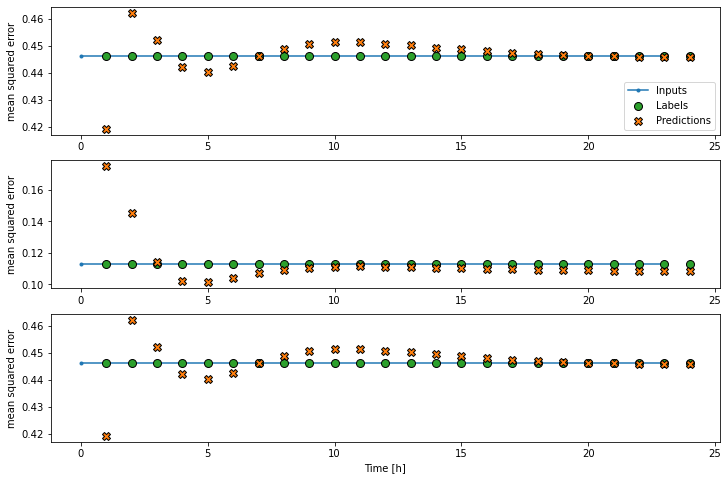

In [111]:
wide_window.plot(lstm_model)